In [1]:
import collections
import time
import numpy as np
import torch
import inspect
from torch import nn
import torchvision
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
from IPython import display
import torchvision.transforms as transforms
from torch.nn import functional as F


In [2]:

def use_svg_display():
    """Use the svg format to display a plot in Jupyter.

    Defined in :numref:`sec_calculus`"""
    backend_inline.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize']=figsize
def set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend):
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()
def plot(X,Y=None,xlabel=None, ylabel=None, legend=[],xlim=None, ylim=None, xscale='linear',yscale='linear',fmts=('-','m--','g-.','r:'),figsize=(3.5,2.5),axes=None):
    def has_one_axis(X):
        return(hasattr(X,'ndim') and X.ndim == 1 or isinstance(X,list) and not hasattr(X[0],"__len__"))
    if has_one_axis(X): X=[X]
    if Y is None:
        X,Y=[[]]*len(X),X
    elif has_one_axis(Y):
        Y=[Y]
    if len(X) != len(Y):
        X=X*len(Y)
    set_figsize(figsize)
    if axes is None:
        axes=plt.gca()
    axes.cla()
    for x,y,fmt in zip (X,Y,fmts):
        axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)
    set_axes(axes,xlabel,ylabel,xlim,ylim,xscale,yscale,legend)

class HyperParameters:
    """The base class of hyperparameters."""
    def save_hyperparameters(self, ignore=[]):
        """Defined in :numref:`sec_oo-design`"""
        raise NotImplemented

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes.

        Defined in :numref:`sec_utils`"""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

class ProgressBoard(HyperParameters):
    """The board that plots data points in animation.

    Defined in :numref:`sec_oo-design`"""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

    def draw(self, x, y, label, every_n=1):
        """Defined in :numref:`sec_utils`"""
        Point = collections.namedtuple('Point', ['x', 'y'])
        if not hasattr(self, 'raw_points'):
            self.raw_points = collections.OrderedDict()
            self.data = collections.OrderedDict()
        if label not in self.raw_points:
            self.raw_points[label] = []
            self.data[label] = []
        points = self.raw_points[label]
        line = self.data[label]
        points.append(Point(x, y))
        if len(points) != every_n:
            return
        mean = lambda x: sum(x) / len(x)
        line.append(Point(mean([p.x for p in points]),
                          mean([p.y for p in points])))
        points.clear()
        if not self.display:
            return
        use_svg_display()
        if self.fig is None:
            self.fig = plt.figure(figsize=self.figsize)
        plt_lines, labels = [], []
        for (k, v), ls, color in zip(self.data.items(), self.ls, self.colors):
            plt_lines.append(plt.plot([p.x for p in v], [p.y for p in v],
                                          linestyle=ls, color=color)[0])
            labels.append(k)
        axes = self.axes if self.axes else plt.gca()
        if self.xlim: axes.set_xlim(self.xlim)
        if self.ylim: axes.set_ylim(self.ylim)
        if not self.xlabel: self.xlabel = self.x
        axes.set_xlabel(self.xlabel)
        axes.set_ylabel(self.ylabel)
        axes.set_xscale(self.xscale)
        axes.set_yscale(self.yscale)
        axes.legend(plt_lines, labels)
        display.display(self.fig)
        display.clear_output(wait=True)


In [3]:
class Module(nn.Module, HyperParameters):
    def __init__(self,plot_train_per_epoch=2, plot_valid_per_epoch=1):
        super().__init__()
        self.save_hyperparameters()
        self.board= ProgressBoard()
    def squared_loss(self,y_hat,y):
        return(y_hat-y.reshape(y_hat.shape))**2/2
    def forward(self, X):
        assert hasattr(self, 'net'), 'Neural Network is defined'
        return self.net(X)
    def plot(self, key, value, train):
        assert hasattr(self,'trainer'), 'Trainer is not inited'
        self.board.xlabel='epoch'
        if train:
            x= self.trainer.train_batch_idx / \
                self.trainer.num_train_batches
            n=self.trainer.num_train_batches / \
                self.plot_train_per_epoch
        else:
            x=self.trainer.epoch+1
            n=self.trainer.num_val_batches / \
                self.plot_valid_per_epoch
        if isinstance(value, int):
            value=torch.tensor(value)
        self.board.draw(x,value.to('cpu').detach().numpy(), ('train_' if train else 'val_')+key, every_n=int(n))

    def training_step(self, batch):
        l=self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=True)
        return l
    def validation_step(self,batch):
        l=self.loss(self(*batch[:-1]), batch[-1])
        self.plot('loss', l, train=False)
    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(),lr=self.lr)
    def  apply_init(self, inputs, init=None):
        self.forward(*inputs)
        if init is not None:
            self.net.apply(init)

In [4]:
class DataModule(HyperParameters):
    def __init__(self, root='./data', num_workers=4):
        self.save_hyperparameters()
    def get_dataloader(self,train):
        i=slice(0,self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)
    def train_dataloader(self):
        return self.get_dataloader(train=True)
    def val_dataloader(self):
        return self.get_dataloader(train=False)
    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)


In [5]:
def gpu(i=0):
    return torch.device(f'cuda:{i}')
def num_gpus():
    return torch.cuda.device_count()
class Trainer(HyperParameters):
    def __init__(self, max_epochs, num_gpus_arg=0, gradient_clip_val=0):
        self.save_hyperparameters()
        self.gpus=[gpu(i) for i in range(min(num_gpus_arg, num_gpus()))]
    def prepare_data(self,data):
        self.train_dataloader=data.train_dataloader()
        self.val_dataloader=data.val_dataloader()
        self.num_train_batches=len(self.train_dataloader)
        self.num_val_batches=(len(self.val_dataloader) if self.val_dataloader is not None else 0)
    def prepare_model(self,model):
        model.trainer=self
        model.board.xlim=[0,self.max_epochs]
        if self.gpus:
            model.to(self.gpus[0])
        self.model=model
    def fit(self,model,data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim=model.configure_optimizers()
        self.epoch=0
        self.train_batch_idx=0
        self.val_batch_idx=0
        for self.epoch in range(self.max_epochs):
            self.fit_epoch()
    def fit_epoch(self):
        self.model.train()
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            with torch.no_grad():
                loss.backward()
                if self.gradient_clip_val > 0: # To be discussed later
                    self.clip_gradients(self.gradient_clip_val, self.model)
                self.optim.step()
            self.train_batch_idx += 1
        if self.val_dataloader is None:
            return
        self.model.eval()
        for batch in self.val_dataloader:
            with torch.no_grad():
                self.model.validation_step(self.prepare_batch(batch))
            self.val_batch_idx += 1
    def prepare_batch(self,batch):
        if self.gpus:
            batch=[a.to(self.gpus[0]) for a in batch]
        return batch



In [6]:
class Classifier(Module):
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)
        self.plot('acc', self.accuracy(Y_hat, batch[-1]), train=False)
    def accuracy(Self, Y_hat, Y, averaged=True):
        Y_hat= Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds=Y_hat.argmax(axis=1).type(Y.dtype)
        compare=(preds==Y.reshape(-1)).type(torch.float32)
        return compare.mean() if averaged else compare
    def layer_summary(self,X_shape):
        X=torch.randn(*X_shape)
        for layer in self.net:
            X=layer(X)
            print(layer.__class__.__name__, 'output shape: \t', X.shape)

In [7]:
use_svg_display()
class FashionMNIST(DataModule):
    def __init__(self, batch_size=64, resize=(28,28)):
        super().__init__()
        self.save_hyperparameters()
        trans=transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.train=torchvision.datasets.FashionMNIST(root=self.root, train=True, transform=trans, download=True)
        self.val=torchvision.datasets.FashionMNIST(root=self.root, train=False, transform=trans, download=True)
    def text_labels(self, indices):
        labels = ['t-shirt','trouser','pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker','bag', 'ankle boot']
        return [labels[int(i)] for i in indices]
    def get_dataloader(self,train):
        data=self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train, num_workers=self.num_workers)
    def visualize(self,batch, nrows=1, ncols=8, labels=[]):
        X,y=batch
        if not labels:
            labels=self.text_labels(y)
        show_images(X.squeeze(1), nrows, ncols, titles=labels)

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize=(num_cols*scale, num_rows*scale)
    _ , axes=plt.subplots(num_rows, num_cols, figsize=figsize)
    axes=axes.flatten()
    for i , (ax, img) in enumerate (zip(axes, imgs)):
        try:
            img=img.detach().numpy()
        except:
            pass
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


In [8]:
def batch_norm(X,gamma, beta, moving_mean, moving_var, eps, momentum):
  if not torch.is_grad_enabled():
    X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
  else:
    assert len(X.shape) in (2, 4)
    if len(X.shape) == 2:
      mean = X.mean(dim=0)
      var = ((X - mean) ** 2).mean(dim=0)
    else:
      mean = X.mean(dim=(0, 2, 3), keepdim=True)
      var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
    X_hat = (X - mean) / torch.sqrt(var + eps)
    moving_mean = (1-momentum)* moving_mean + momentum * mean
    moving_var = (1- momentum) * moving_var + momentum * var
  Y=gamma * X_hat + beta
  return Y, moving_mean.data, moving_var.data
class BatchNorm(nn.Module):
  def __init__(self, num_features, num_dims):
    super().__init__()
    if num_dims == 2:
      shape = (1, num_features)
    else:
      shape = (1, num_features, 1, 1)
    self.gamma=nn.Parameter(torch.ones(shape))
    self.beta=nn.Parameter(torch.zeros(shape))
    self.moving_mean = torch.zeros(shape)
    self.moving_var = torch.ones(shape)
  def forward(self, X):
    if self.moving_mean.device != X.device:
      self.moving_mean = self.moving_mean.to(X.device)
      self.moving_var = self.moving_var.to(X.device)
    Y, self.moving_mean, self.moving_var = batch_norm(
        X, self.gamma, self.beta, self.moving_mean,
        self.moving_var, eps=1e-5, momentum=0.9)
    return Y

In [10]:

def init_cnn(module):
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)
class BNLeNetScratch(Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net=nn.Sequential(
            nn.LazyConv2d(6,kernel_size=5,padding=2), BatchNorm(6,num_dims=4), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), BatchNorm(16,num_dims=4), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
            nn.LazyLinear(84), BatchNorm(84, num_dims=2),nn.Sigmoid(),
            nn.LazyLinear(num_classes))
    def loss(self, Y_hat, Y, averaged=True):
        Y_hat=Y_hat.reshape((-1, Y_hat.shape[-1]))
        Y=Y.reshape((-1,))
        return F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')


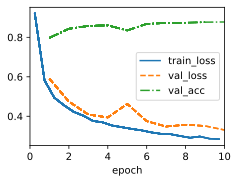

In [11]:
trainer=Trainer(max_epochs=10, num_gpus_arg=1)
data=FashionMNIST(batch_size=128)
model=BNLeNetScratch(lr=0.1)
model.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model,data)
plt.show()


In [13]:
model.net[1].gamma.reshape((-1,)),model.net[1].beta.reshape((-1,))

(tensor([1.2367, 1.6332, 2.1627, 2.4231, 2.3294, 1.0200], device='cuda:0',
        grad_fn=<ViewBackward0>),
 tensor([-0.8635,  0.2765,  1.2840,  1.3968,  0.7067, -0.4660], device='cuda:0',
        grad_fn=<ViewBackward0>))

Concise Implement

In [15]:
class BNLeNet(Classifier):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.net=nn.Sequential(
            nn.LazyConv2d(6,kernel_size=5,padding=2), nn.LazyBatchNorm2d(), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.LazyBatchNorm2d(), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.LazyBatchNorm1d(), nn.Sigmoid(),
            nn.LazyLinear(84), nn.LazyBatchNorm1d(),nn.Sigmoid(),
            nn.LazyLinear(num_classes))
    def loss(self, Y_hat, Y, averaged=True):
        Y_hat=Y_hat.reshape((-1, Y_hat.shape[-1]))
        Y=Y.reshape((-1,))
        return F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')


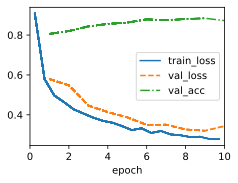

In [16]:
model2=BNLeNet(lr=0.1)
model2.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(model2,data)